In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import math
from torch import nn
from scipy.fftpack import fft
from tqdm import tqdm
from itertools import chain

torch.manual_seed(42)

In [2]:
class Butterfly(nn.Module):
    def __init__(self, n_points):
        super(Butterfly, self).__init__()
        self.n = n_points
        self.w_left = nn.Conv1d(n_points, n_points//2, 1)
        self.w_right = nn.Conv1d(n_points, n_points//2, 1)
    
    def forward(self, x):
        return (self.w_left(x), self.w_right(x))

class RecursiveFly(nn.Module):
    def __init__(self, n_points):
        super(RecursiveFly, self).__init__()
        self.n = n_points
        self.butter = Butterfly(n_points)
        if n_points > 2:
            self.layer = RecursiveFly(n_points//2)

    def forward(self, x):
        y_left, y_right = self.butter(x)
        if self.n > 2:
            y_left = self.layer(y_left)
            y_right = self.layer(y_right)
            return [*y_left, *y_right]
        return [y_left, y_right]

class Model(nn.Module):
    def __init__(self, n_points):
        super(Model, self).__init__()
        order_bitwidth = int(math.log(n_points)/math.log(2))
        self.order = [int('{:0{width}b}'.format(n, width=order_bitwidth)[::-1], 2) for n in range(0, n_points)]
        self.layer = RecursiveFly(n_points)
    
    def forward(self, x):
        y = self.layer(x)
        return torch.cat([y[o] for o in self.order], dim=1)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = int(1e3)
n_points = 16

model = Model(n_points).to(device)
criterion = nn.SmoothL1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

epochs = int(5e4)
print_time = epochs // 10

In [4]:
for epoch in tqdm(range(epochs), "IDFTing", position=0):
    # Generating inputs/outputs
    y = np.random.rand(batch_size, n_points)
    x = fft(y)

    # Preparing for pytorch
    x_r = torch.tensor(x.real).view(batch_size, -1, 1).float().to(device)
    x_j = torch.tensor(x.imag).view(batch_size, -1, 1).float().to(device)
    y = torch.tensor(y).float().to(device)

    # Calculating IDFT
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj)

    # Optimizing
    optimizer.zero_grad()
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()

    # Logging
    if epoch % print_time == 0:
        tqdm.write(f"{epoch}:: {loss.item()}")

IDFTing:   0%|          | 9/50000 [00:00<2:16:45,  6.09it/s]

0:: 3309.15576171875


IDFTing:  10%|█         | 5013/50000 [01:07<10:10, 73.67it/s]

5000:: 337.33056640625


IDFTing:  20%|██        | 10013/50000 [02:14<08:48, 75.69it/s]

10000:: 164.52386474609375


IDFTing:  30%|███       | 15010/50000 [03:22<07:47, 74.87it/s]

15000:: 0.018089652061462402


IDFTing:  40%|████      | 20016/50000 [04:29<06:34, 76.09it/s]

20000:: 1.5124841468150407e-07


IDFTing:  50%|█████     | 25010/50000 [05:35<05:25, 76.74it/s]

25000:: 2.524107003409881e-07


IDFTing:  60%|██████    | 30011/50000 [06:41<04:24, 75.71it/s]

30000:: 0.00016583380056545138


IDFTing:  70%|███████   | 35011/50000 [07:46<03:22, 74.16it/s]

35000:: 1.0417611912005853e-10


IDFTing:  80%|████████  | 40011/50000 [08:52<02:16, 73.23it/s]

40000:: 7.455517092580521e-09


IDFTing:  90%|█████████ | 45010/50000 [09:58<01:03, 78.25it/s]

45000:: 3.335595829412341e-05


IDFTing: 100%|██████████| 50000/50000 [11:04<00:00, 75.30it/s]


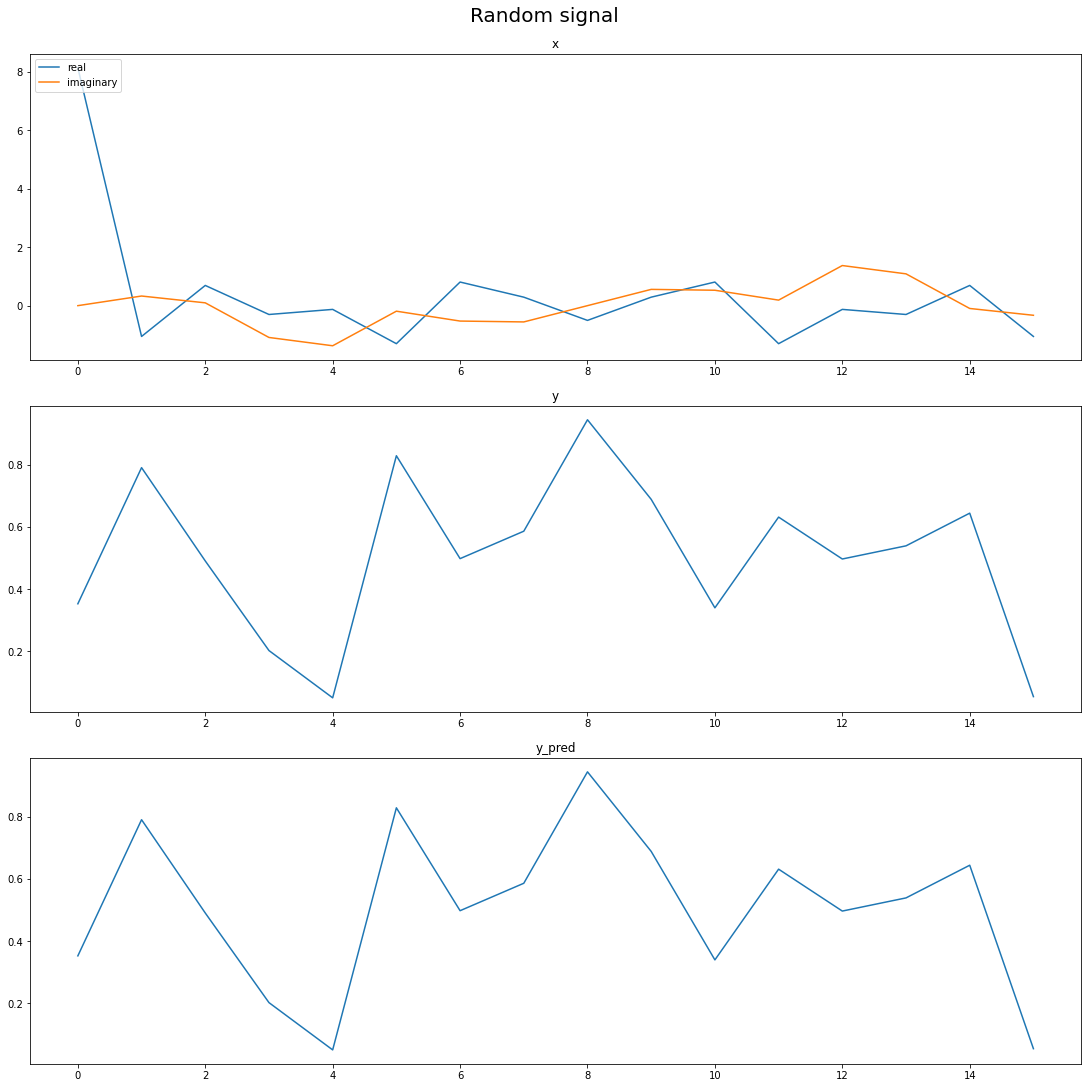

In [5]:
y = np.random.rand(1, n_points)
x = fft(y)
x_r = torch.tensor(x.real).view(1, -1, 1).float().to(device)
x_j = torch.tensor(x.imag).view(1, -1, 1).float().to(device)
with torch.no_grad():
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj).cpu().numpy()
fig, ax = plt.subplots(3, figsize=(15, 15), constrained_layout=True)
ax[0].plot(x[0].real, label='real')
ax[0].plot(x[0].imag, label='imaginary')
ax[0].set_title("x")
ax[0].legend(loc="upper left")
ax[1].plot(y[0])
ax[1].set_title("y")
ax[2].plot(y_pred)
ax[2].set_title("y_pred")
fig.suptitle("Random signal", fontsize=20)
fig.show()

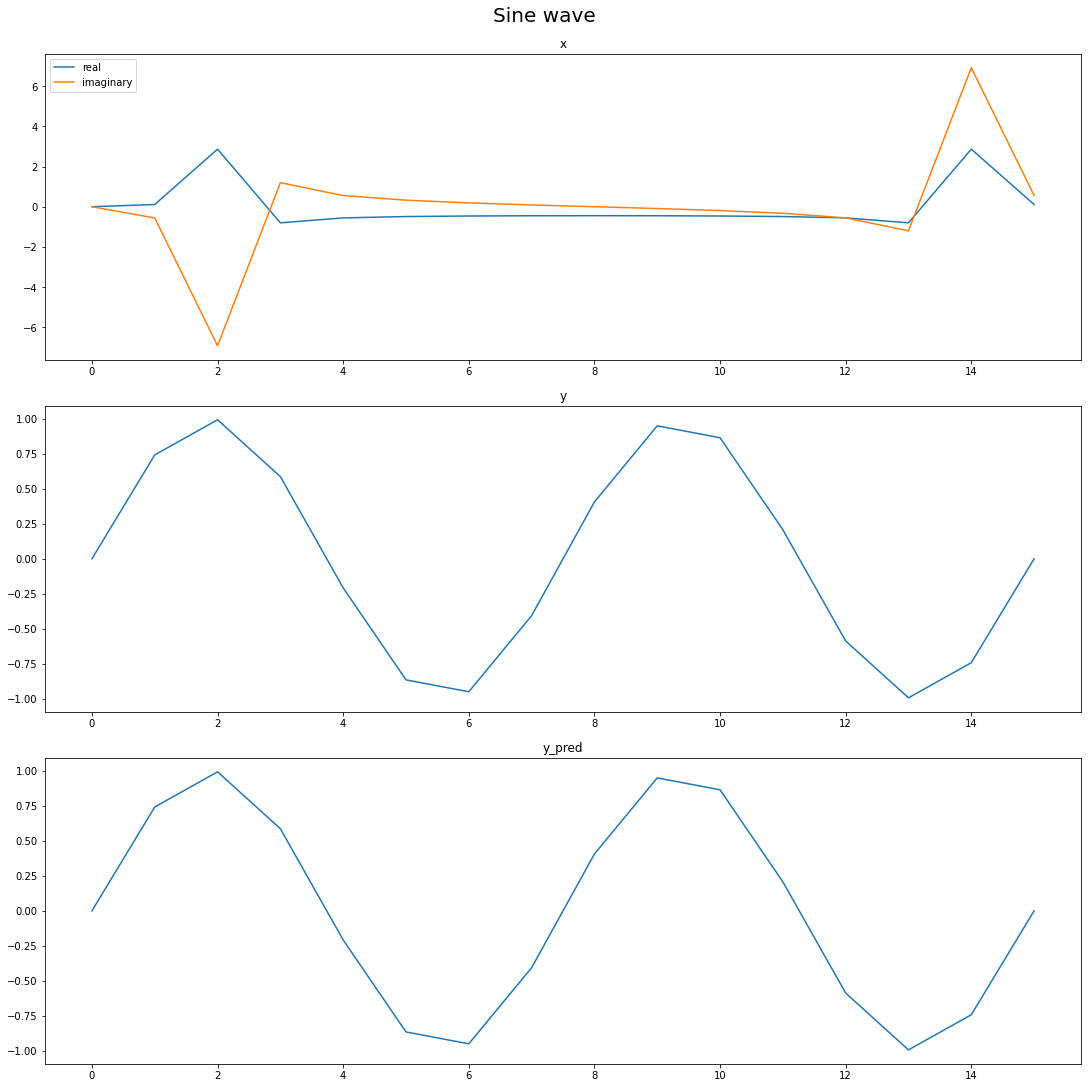

In [6]:
y = np.sin(np.linspace(-2*np.pi, 2*np.pi, n_points))
x = fft(y)
x_r = torch.tensor(x.real).view(1, -1, 1).float().to(device)
x_j = torch.tensor(x.imag).view(1, -1, 1).float().to(device)
with torch.no_grad():
    y_predr = model(x_r).squeeze()
    y_predj = model(x_j).squeeze()
    y_pred = (y_predr + y_predj).cpu().numpy()
fig, ax = plt.subplots(3, figsize=(15, 15), constrained_layout=True)
ax[0].plot(x.real, label='real')
ax[0].plot(x.imag, label='imaginary')
ax[0].set_title("x")
ax[0].legend(loc="upper left")
ax[1].plot(y)
ax[1].set_title("y")
ax[2].plot(y_pred)
ax[2].set_title("y_pred")
fig.suptitle("Sine wave", fontsize=20)
fig.show()